In [1]:
# import necessary libraries

import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [2]:
# create flags and directory locations for saves

save_weights = True # save model weights to disc
load_weights = False # load model weights from disc
save_images = True # save a 4x4 sample array of faces as training progresses
image_saves_location = "image_saves\\" # location in parent folder to save sample array images
parametric_interpolation_location = "parametric_interpolation\\" # location in parent folder to save results of parametric latent space interpolation

In [3]:
# Obtain the dataset
image_size = (32, 32) # training set image size (width x height)
channels = 3 # number of channels in image (RGB=3)

parent_path = Path(os.getcwd()).parent.absolute() # get parent folder path
data_path = os.path.join(parent_path, "dataset\img_align_celeba") # construct the full data source path via concatenation 
dataset = tf.keras.preprocessing.image_dataset_from_directory(data_path, labels=None, image_size=image_size) # create a keras Dataset object from the image directory

Found 202599 files belonging to 1 classes.


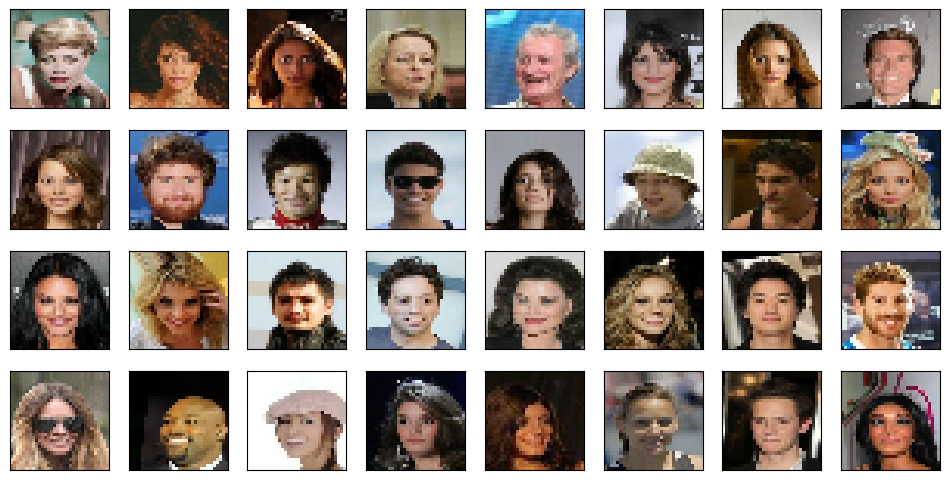

In [4]:
# Visualize the dataset

display_sample = next(dataset.take(1).as_numpy_iterator()) # takes one batch of default size 32
fig, axes = plt.subplots(nrows=4, ncols=8, figsize = (12, 6))
for i in range(4):
    for j in range(8):
        axes[i, j].imshow(display_sample[i*8+j]/255) # divide by 255 to map pixels to [0, 1]
        axes[i, j].grid(False) # turn off grid
        axes[i, j].set_xticks([]) # remove x ticks
        axes[i, j].set_yticks([]) # remove y ticks
plt.show()

In [5]:
# Define the generator and discriminator models

# function to return generator model
def get_generator_model(latent_dim):
    input = tf.keras.Input(shape=(latent_dim,))

    X = tf.keras.layers.Dense(32*32*32)(input)
    X = tf.keras.layers.LeakyReLU()(X)
    X = tf.keras.layers.Reshape(target_shape=(32, 32, 32))(X)

    X = tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same')(X)
    X = tf.keras.layers.LeakyReLU()(X)

    X = tf.keras.layers.Conv2D(filters=channels, kernel_size=5, strides=1, padding='same', activation='tanh')(X)

    model = tf.keras.Model(inputs=input, outputs=X)
    return model

# function to return discriminator model
def get_discriminator_model():
    input = tf.keras.Input(shape=(image_size[0], image_size[1], channels))

    X = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(input)
    X = tf.keras.layers.LeakyReLU()(X)

    X = tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2)(X)
    X = tf.keras.layers.LeakyReLU()(X)

    X = tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2)(X)
    X = tf.keras.layers.LeakyReLU()(X)

    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dropout(rate=0.2)(X)

    X = tf.keras.layers.Dense(1, activation='sigmoid')(X)

    model = tf.keras.Model(inputs=input, outputs=X)
    return model

In [6]:
# Define the model and any model hyperparameters

latent_dim = 32 # size of latent vector used to generate fake images mimicking the target distribution 
generator = get_generator_model(latent_dim) # create the generator network that accepts vectors of size latent_dim
discriminator = get_discriminator_model() # create the discriminator network
print(generator.summary())
print(discriminator.summary())
batch_size = 16 # number of example images handled at a time
k = 3 # number of discriminator training steps per generator training step to ensure the discriminator is optimal for a fixed set of generator weights
training_iterations = 2000 # number of iterations of (discriminator+generator) training

# define the overall GAN model
gan_input = tf.keras.Input(shape=(latent_dim,)) # define the inputs
gan_output = discriminator(generator(gan_input)) # define the output as a composition of the generator and discriminator
gan_model = tf.keras.Model(inputs = gan_input, outputs=gan_output) # define the model
print(gan_model.summary())

generator_optimizer =  tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-4, clipvalue=1, decay=1e-8) # optimizer to perform gradient updates on the generator
discriminator_optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-4, clipvalue=1, decay=1e-8) # optimizer to perform gradient updates on the discriminator

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 32)        0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 3)         4803  

In [7]:
# rebatch the dataset according to the batch size defined
dataset = dataset.unbatch().batch(batch_size=batch_size)

In [8]:
# Perform the main training algorithm by forward and backpropagation on the generator and discriminator

# load model weights from disc if flag True
if load_weights:
    generator.load_weights(os.path.join(parent_path, "model_saves/generator.weights.h5"))
    discriminator.load_weights(os.path.join(parent_path, "model_saves/discriminator.weights.h5"))

# create location to save model weights if flag True
if save_weights:
    try:
        os.mkdir(os.path.join(parent_path, "model_saves/"))
    except FileExistsError:
        pass

generator_losses = [] # list to store history of generator losses
discriminator_losses = [] # list to store history of discriminator losses

# create location to save sample image array
if save_images == True:
    image_saves_location = os.path.join(parent_path, image_saves_location)
    constant_latent_vectors = np.random.normal(size=(4*4, latent_dim)) # these input vectors provide a standard for comparison as training progresses
    try:
        os.mkdir(image_saves_location) # try to create folder
        print(f"Created folder {image_saves_location}")
    except FileExistsError:
        print("Folder exists, proceeding to training")

data_iterator = dataset.as_numpy_iterator() # create an iterator object to access the dataset in the form of numpy arrays
for i in tqdm(range(training_iterations)):
    for j in range(k):
        noise_sample = np.random.normal(size=(batch_size, latent_dim)) # random sample latent vector
        try: 
            real_sample = next(data_iterator)/255 # extract the next batch from the dataset
        except StopIteration: # end of dataset
            data_iterator = dataset.as_numpy_iterator() # reinitialize the iterator
            real_sample = next(data_iterator)/255 # extract the next batch from the dataset
        fake_sample = generator(noise_sample) # pass the latent vector through the generator model
        real_labels = np.ones(shape=(real_sample.shape[0], 1)) # 1 indicates real image
        fake_labels = np.zeros(shape=(batch_size, 1)) # 0 indicates fake image
        concatenated_input = np.concatenate([real_sample, fake_sample], axis=0) # make a double batch of one real batch and one fake batch (hence double the batch size)
        y = np.concatenate([real_labels, fake_labels], axis=0) # make the corresponding labels for the double batch
        concatenated_input = tf.convert_to_tensor(concatenated_input) # convert to tf tensor for GradientTape() to work
        y = tf.convert_to_tensor(y) # convert to tf tensor for GradientTape() to work
    
        with tf.GradientTape() as tape: # create a GradientTape() to keep track of operations
            y_predicted = tf.cast(discriminator(concatenated_input), dtype=tf.float64) # pass the double batch through the discriminator
            loss = tf.reduce_sum(-tf.math.multiply(y, tf.math.log(y_predicted)) - tf.math.multiply(1-y, tf.math.log(1-y_predicted)))/(batch_size*2) # compute the negative log-loss (binary crossentropy)
        gradients = tape.gradient(loss, discriminator.trainable_variables) # compute gradients with respect to discriminator parameters
        discriminator_optimizer.apply_gradients(list(zip(gradients, discriminator.trainable_variables))) # perform gradient descent to minimise the negtive log-loss
        discriminator_losses.append(loss) # add loss to list

    noise_sample = np.random.normal(size=(batch_size, latent_dim)) # create a batch of random latent vectors   
    y = np.zeros(shape=(batch_size, 1)) # create "1" labels for this batch even though it's fake, because the generator aims to fool the discriminator
    y = tf.convert_to_tensor(y) # convert to tf tensor for GradientTape() to work
    with tf.GradientTape() as tape: # create a GradientTape() to keep track of operations
        y_predicted = tf.cast(gan_model(noise_sample), dtype=tf.float64) # pass the random latent vectors through the whole gan model and convert to float64 for further operations to work correctly
        loss = tf.reduce_sum(tf.math.log(1-y_predicted))/(batch_size*2) # positive log loss (only the second term in binary cross entropy depends on the generator because y=0 so (1-y)log(1-y_hat) survives) which needs to be minimized by the generator
    gradients = tape.gradient(loss, generator.trainable_variables) # compute gradients with respect to generator parameters 
    generator_optimizer.apply_gradients(list(zip(gradients, generator.trainable_variables))) # perform gradient descent to minimise the positive log-loss
    generator_losses.append(loss) # add loss to list
    
    # save the model weights if flag True
    if save_weights==True and i%5 == 0: # every 5 iterations
        generator.save_weights(os.path.join(parent_path, "model_saves\generator.weights.h5"))
        discriminator.save_weights(os.path.join(parent_path, "model_saves\discriminator.weights.h5"))      

    # save the sample image array if flag True
    if save_images == True and i%5 == 0: # every 5 iterations
        fake_images = generator(constant_latent_vectors) # pass the constant latent vectors through the generator
        new_img_array = np.zeros(shape=(image_size[0]*4, image_size[1]*4, channels)) # initialize a zero-array to hold the sample image array
        for j in range(4): # 4 rows
            for k in range(4): # 4 columns
                new_img_array[j*image_size[0]:(j+1)*image_size[0], k*image_size[1]:(k+1)*image_size[1], :] = fake_images[j*4+k] # write the fake image to the correct location in the array
        new_img_array = (255*np.clip(new_img_array, 0, 1)).astype(np.uint8) # convert to [0, 255] integers
        new_img = Image.fromarray(new_img_array, mode="RGB") # create a PIL Image object
        new_img.save(image_saves_location+f"img_{i//5}.png", format="png") # save the image

Created folder v:\Work_and_Files\Siddhartha Rajeev\Electronics and Programming\Data Science and Machine Learning\generative_adversarial_network_1\image_saves\


100%|██████████| 2000/2000 [13:17<00:00,  2.51it/s]


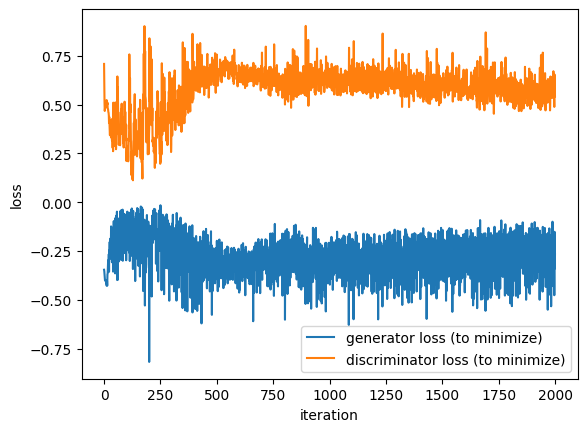

In [9]:
# visualize the loss of both generator and discriminator

fig, ax = plt.subplots()
ax.plot(generator_losses, label="generator loss (to minimize)")
plt.plot(discriminator_losses[::k], label="discriminator loss (to minimize)")
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
ax.legend()

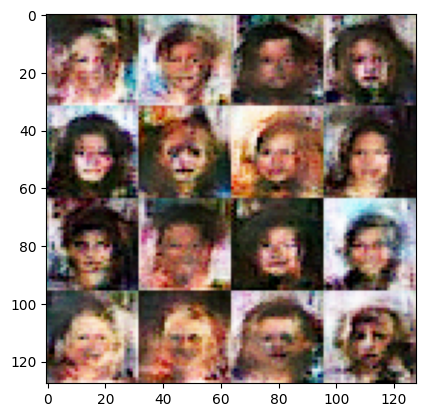

In [10]:
# visualize the latest sample image array just like in the training loop above

fake_images = generator(constant_latent_vectors)
new_img_array = np.zeros(shape=(image_size[0]*4, image_size[1]*4, channels))
for j in range(4):
    for k in range(4):
        new_img_array[j*image_size[0]:(j+1)*image_size[0], k*image_size[1]:(k+1)*image_size[1], :] = fake_images[j*4+k]
new_img_array = (255*np.clip(new_img_array, 0, 1)).astype(np.uint8)
plt.imshow(new_img_array)

Folder created, proceeding with saving interpolation results


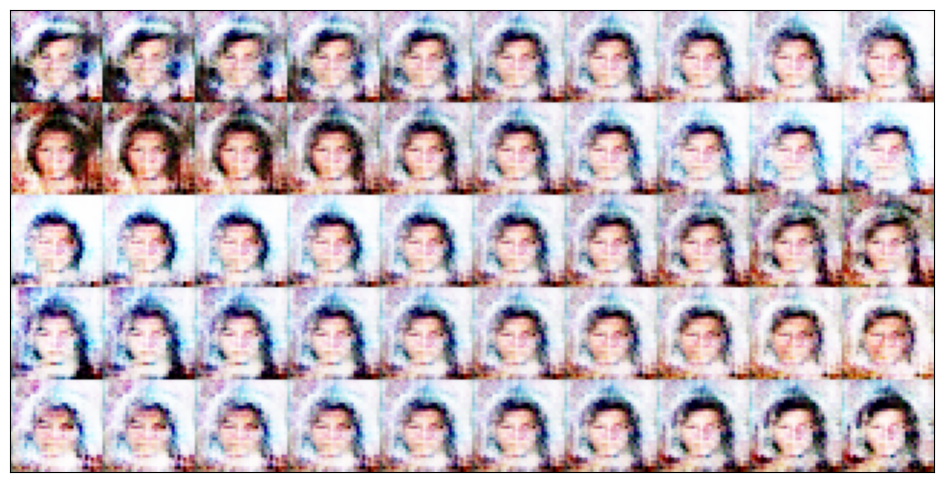

In [11]:
# Paramteric latent space interpolation
n_rows = 5 # number of latent varaibel coordinates (must be less than latent_dim)
n_cols = 10 # number of interpolation points (endpoints inclusive)

latent_vectors = np.zeros(shape=(n_rows, n_cols, latent_dim,)) # initialize the latent vectors array to zeros
constant_random_vector = np.random.normal(size=(latent_dim,)) # this constant random vector provides a ceteris-paribus standard for comparison when we vary a single latent coordinate at a time
random_indices = np.random.choice(range(latent_dim), n_rows) # pick a random set of n_rows latent coordinates
latent_interpolation = np.linspace(-4, 4, n_cols) # an array of the interpolated points
for i in range(n_rows): # for each latent coordinate of interest 
    for j in range(n_cols): # for each interpolation point
        latent_vectors[i,j] = constant_random_vector # default ceteris-paribus vector
        latent_vectors[i,j, random_indices[i]] = latent_interpolation[j] # only change the coordinate of interest in this row to the correct interpolation value
latent_vectors = np.reshape(latent_vectors, newshape=(-1, latent_dim)) # reshape it to (n_rows*n_cols, latent_dim) to pass it into the generator
fake_images = generator(latent_vectors) # generate fake images by passing the latent vectors into the generator
img_array = np.zeros(shape=(image_size[0]*n_rows, image_size[1]*n_cols, channels)) # initialize a zero array to hold the interpolation results
for i in range(n_rows): # for each latent coordinate of interest
    for j in range(n_cols): # for each interpolation point
        img_array[i*image_size[0]:(i+1)*image_size[0], j*image_size[1]:(j+1)*image_size[1], :] = fake_images[i*n_cols+j] # write the fake image to the correct location in the array
img_array = (255*np.clip(img_array, 0, 1)).astype(np.uint8) # convert to [0, 255] integers

# display
plt.figure(figsize=(12, 6))
plt.imshow(img_array)
plt.grid(False) # no grid
plt.xticks([]) # no x ticks
plt.yticks([]) # no y ticks

parametric_interpolation_location = os.path.join(parent_path, parametric_interpolation_location) # create the full path to save the interpolation results
try:
    os.mkdir(parametric_interpolation_location) # try to create folder
    print("Folder created, proceeding with saving interpolation results")
except FileExistsError:
    print("Folder exists, proceeding with saving interpolation results")
img = Image.fromarray(img_array, mode="RGB") # create PIL Image object
img.save(parametric_interpolation_location+"interpolation_1.png") # save image